<a href="https://colab.research.google.com/github/ppkgtmm/sentiment/blob/utils/MLP_3H.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# !pip install keras-tuner
# !rm -r sentiment
# !git clone --branch utils https://github.com/ppkgtmm/sentiment.git sentiment

In [3]:
import pandas as pd
from keras.preprocessing.text import  Tokenizer
from keras.layers import Input, Dense
from keras.models import Sequential
from keras.metrics import Precision, Recall, FalseNegatives, \
FalsePositives, TrueNegatives, TruePositives
from kerastuner import HyperParameters
import matplotlib.pyplot as plt
from sentiment.utils import read_data, get_optimizer, get_sequences, split_data
from sentiment.utils import get_tuner, get_model_from_config, get_callbacks
from sentiment.utils import OH_fit_transform, OH_transform, load, dump, \
model_evaluate

In [4]:

cols = ['text', 'target']
data_path = '/content/drive/MyDrive/sentiment/data/data_preprocessed.csv'
test_path = '/content/drive/MyDrive/sentiment/data/test_data_preprocessed.csv'
seed = 123456
num_words = 10000
max_len = 250
optimizers = [
           'Adam',
           'RMSprop'   
]
activations = ['sigmoid']

In [5]:
data = read_data(data_path,cols)

In [6]:
data.sample(5)

,text,target
277062,poorly organized poorly organized try looking ...,0
198730,not very flavorful would not buy this flavor a...,0
80005,emotional i really was excited to see that cha...,1
8714,drunk a log what a disappointment no depth a p...,0
55461,making it her own what an amazing album i was ...,1


In [7]:
train, val = split_data(data)

In [8]:
train.shape, val.shape

((305988, 2), (53998, 2))

In [15]:
test = read_data(test_path, cols)
test.sample(5)

,text,target
5292,great product for a small environmental impact...,1
653,not very detailed this book has a bunch of gen...,0
14869,clear and concise but requires supplementation...,1
12841,not all bad but pretty earthy crunchy the basi...,0
8929,overrated disappointing yet it could have been...,0


## Text preprocessing

In [ ]:
tokenizer = Tokenizer(num_words=num_words, oov_token='OOV')
tokenizer.fit_on_texts(train['text'])

In [ ]:
sequence_train = get_sequences(tokenizer, max_len, train['text'])
sequence_val = get_sequences(tokenizer, max_len, val['text'])

## Target preprocessing

In [9]:
print(val['target'].unique(), train['target'].unique())

[1 0] [0 1]


In [16]:
train_target = OH_fit_transform(train['target'])
val_target = OH_transform(val['target'])
test_target = OH_transform(test['target'])

In [17]:
train_target.shape, val_target.shape, test_target.shape

((305988, 2), (53998, 2), (20000, 2))

## MLP 3H

In [ ]:
def build_mlp(hp):
    model = Sequential()
    model.add(Input(shape=(max_len,)))
    units = hp.get('hidden_units')
    model.add(Dense(units,\
                           activation=hp.get("hidden_activation")))
    model.add(Dense(units+10,\
                           activation=hp.get("hidden_activation")))
    model.add(Dense(units,\
                           activation=hp.get("hidden_activation")))
    model.add(Dense(2, activation='softmax'))
    model.compile(
        optimizer=hp.get('optimizer'),
        loss='categorical_crossentropy',
        metrics=[
                 'accuracy',
                 Precision(), 
                 Recall(),
                 TruePositives(), 
                 TrueNegatives(), 
                 FalsePositives(),
                 FalseNegatives()
              ]
          )
    model.summary()
    return model

In [ ]:
hp = HyperParameters()
hp.Int('hidden_units', 10, 30, 10)
hp.Choice('hidden_activation', activations)
hp.Choice('optimizer', optimizers)

'Adam'

In [ ]:
tuner = get_tuner(build_mlp,'/content/drive/MyDrive/sentiment/MLP','MLP_3H_B32', hp)

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/sentiment/MLP/MLP_3H_B32/oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                2510      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total params: 2,962
Trainable params: 2,962
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/sentiment/MLP/MLP_3H_B32/tuner0.json


## Train

In [ ]:
history = tuner.search(
    sequence_train,
    train_target,
    epochs=4,
    validation_data=(sequence_val, val_target),
    batch_size=32
)

## Refit


In [ ]:
mlp_3h = tuner.get_best_models(num_models=1)[0]
max_len = mlp_3h.get_config()["layers"][0]["config"]["batch_input_shape"][1]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                7530      
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 62        
Total params: 10,062
Trainable params: 10,062
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tokenizer = load('/content/drive/MyDrive/sentiment/MLP/MLP_3H_B32/tokenizer.pickle')

In [ ]:
seq_train = get_sequences(tokenizer,max_len,train['text'])
seq_val = get_sequences(tokenizer,max_len,val['text'])

In [ ]:
mlp_3h = get_model_from_config(
    mlp_3h, 
    tuner.get_best_hyperparameters()[0].get('optimizer')
    )

In [ ]:
history_3h = mlp_3h.fit(
    seq_train,
    train_target,
    validation_data=(seq_val, val_target),
    epochs=100,
    callbacks=get_callbacks('mlp_3H.h5')
)

Epoch 1/100
9563/9563 [==============================] - 21s 2ms/step - loss: 0.6941 - accuracy: 0.5128 - precision: 0.5128 - recall: 0.5128 - true_positives: 79123.0088 - true_negatives: 79123.7391 - false_positives: 73916.2517 - false_negatives: 73916.9820 - val_loss: 0.6893 - val_accuracy: 0.5359 - val_precision: 0.5359 - val_recall: 0.5359 - val_true_positives: 28936.0000 - val_true_negatives: 28936.0000 - val_false_positives: 25062.0000 - val_false_negatives: 25062.0000

Epoch 00001: val_loss improved from inf to 0.68930, saving model to mlp_3H.h5
Epoch 2/100
9563/9563 [==============================] - 19s 2ms/step - loss: 0.6904 - accuracy: 0.5299 - precision: 0.5299 - recall: 0.5299 - true_positives: 81179.4253 - true_negatives: 81179.4253 - false_positives: 71860.5655 - false_negatives: 71860.5655 - val_loss: 0.6897 - val_accuracy: 0.5343 - val_precision: 0.5343 - val_recall: 0.5343 - val_true_positives: 28852.0000 - val_true_negatives: 28852.0000 - val_false_positives: 25146.

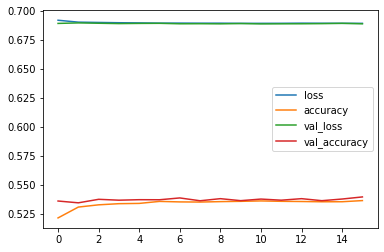

In [ ]:
metr = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
pd.DataFrame(history_3h.history)[metr].plot()

In [ ]:
# dump(history_3h.history, '/content/drive/MyDrive/sentiment/MLP/MLP_3H_B32/history.pickle')

In [ ]:
test_seq = get_sequences(tokenizer,max_len, test['text'])

  1/625 [..............................] - ETA: 1:09

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


625/625 [==============================] - 1s 849us/step
Accuracy:	53.6%


              precision    recall  f1-score   support

           0       0.53      0.69      0.60     10000
           1       0.55      0.38      0.45     10000

    accuracy                           0.54     20000
   macro avg       0.54      0.54      0.52     20000
weighted avg       0.54      0.54      0.52     20000



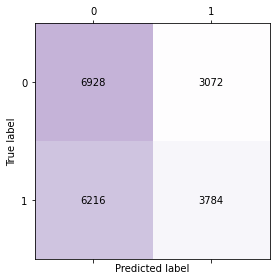

In [ ]:
model_evaluate(mlp_3h, test_seq, test_target, 32)

## Insights

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
hidden_units (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 30, 'step': 10, 'sampling': None}
hidden_activation (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid'], 'ordered': False}
optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'RMSprop'], 'ordered': False}


In [ ]:
tuner.results_summary(num_trials=3)

Results summary
Results in /content/drive/MyDrive/sentiment/MLP/MLP_3H_B32
Showing 3 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
hidden_units: 30
hidden_activation: sigmoid
optimizer: Adam
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.6891468465328217
Trial summary
Hyperparameters:
hidden_units: 30
hidden_activation: sigmoid
optimizer: RMSprop
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.6891677379608154
Trial summary
Hyperparameters:
hidden_units: 20
hidden_activation: sigmoid
optimizer: RMSprop
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.6895217001438141


## OE

In [12]:
def build_OE(hp):
    model = Sequential()
    model.add(Input(shape=(max_len,)))
    units = hp.get('hidden_units')
    model.add(Dense(units,\
                           activation=hp.get("hidden_activation")))
    model.add(Dense(units-10,\
                           activation=hp.get("hidden_activation")))
    model.add(Dense(units,\
                           activation=hp.get("hidden_activation")))
    model.add(Dense(2, activation='softmax'))
    model.compile(
        optimizer=hp.get('optimizer'),
        loss='categorical_crossentropy',
        metrics=[
                 'accuracy',
                 Precision(), 
                 Recall(),
                 TruePositives(), 
                 TrueNegatives(), 
                 FalsePositives(),
                 FalseNegatives()
              ]
          )
    model.summary()
    return model

In [13]:
hp2 = HyperParameters()
hp2.Int('hidden_units', 20, 40, 10)
hp2.Choice('hidden_activation', activations)
hp2.Choice('optimizer', optimizers)

'Adam'

In [14]:
tuner2 = get_tuner(build_OE, '/content/drive/MyDrive/sentiment/MLP', \
                   'MLP_3HOEN_B32', hp2,)

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/sentiment/MLP/MLP_3HOEN_B32/oracle.json
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                5020      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42        
Total params: 5,492
Trainable params: 5,492
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/sentiment/MLP/MLP_3HOEN_B32/tuner0.json


## Train

In [ ]:
history = tuner2.search(
    sequence_train,
    train_target,
    epochs=4,
    validation_data=(sequence_val, val_target),
    batch_size=32
)

Trial 8 Complete [00h 02m 30s]
val_loss: 0.6891522407531738

Best val_loss So Far: 0.6891522407531738
Total elapsed time: 00h 12m 16s
INFO:tensorflow:Oracle triggered exit


## Refit

In [20]:
mlp_3hoen = tuner2.get_best_models(num_models=1)[0]
max_len = mlp_3hoen.get_config()["layers"][0]["config"]["batch_input_shape"][1]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                5020      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 42        
Total params: 5,492
Trainable params: 5,492
Non-trainable params: 0
_________________________________________________________________


In [18]:
tokenizer = load('/content/drive/MyDrive/sentiment/MLP/MLP_3HOEN_B32/tokenizer.pickle')

In [21]:
seq_train = get_sequences(tokenizer,max_len,train['text'])
seq_val = get_sequences(tokenizer,max_len,val['text'])

In [22]:
mlp_3hoen = get_model_from_config(
    mlp_3hoen, 
    tuner2.get_best_hyperparameters()[0].get('optimizer')
    )

In [29]:
history_3hoen = mlp_3hoen.fit(
    seq_train,
    train_target,
    validation_data=(seq_val, val_target),
    epochs=100,
    callbacks=get_callbacks('mlp_3HOEN.h5')
)

Epoch 1/100
9563/9563 [==============================] - 18s 2ms/step - loss: 0.6899 - accuracy: 0.5338 - precision: 0.5338 - recall: 0.5338 - true_positives: 163330.0000 - true_negatives: 163330.0000 - false_positives: 142658.0000 - false_negatives: 142658.0000 - val_loss: 0.6889 - val_accuracy: 0.5378 - val_precision: 0.5378 - val_recall: 0.5378 - val_true_positives: 29041.0000 - val_true_negatives: 29041.0000 - val_false_positives: 24957.0000 - val_false_negatives: 24957.0000

Epoch 00001: val_loss improved from inf to 0.68888, saving model to mlp_3HOEN.h5
Epoch 2/100
9563/9563 [==============================] - 17s 2ms/step - loss: 0.6899 - accuracy: 0.5338 - precision: 0.5338 - recall: 0.5338 - true_positives: 163329.0000 - true_negatives: 163329.0000 - false_positives: 142659.0000 - false_negatives: 142659.0000 - val_loss: 0.6892 - val_accuracy: 0.5381 - val_precision: 0.5381 - val_recall: 0.5381 - val_true_positives: 29054.0000 - val_true_negatives: 29054.0000 - val_false_positi

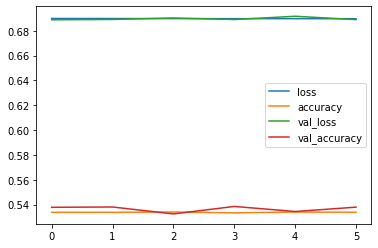

In [30]:
metr = ['loss', 'accuracy', 'val_loss', 'val_accuracy']
pd.DataFrame(history_3hoen.history)[metr].plot()

In [33]:
dump(history_3hoen.history, '/content/drive/MyDrive/sentiment/MLP/MLP_3HOEN_B32/history.pickle')

## Test

 64/625 [==>...........................] - ETA: 0s 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


625/625 [==============================] - 1s 781us/step
Accuracy:	53.6%


              precision    recall  f1-score   support

           0       0.53      0.73      0.61     10000
           1       0.56      0.34      0.42     10000

    accuracy                           0.54     20000
   macro avg       0.54      0.54      0.52     20000
weighted avg       0.54      0.54      0.52     20000



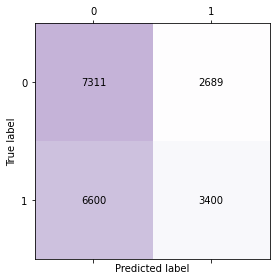

In [32]:
model_evaluate(
    mlp_3hoen,
    get_sequences(tokenizer,max_len,test['text']),
    test_target,
    batch_size=32
)

## Insights

In [ ]:
tuner2.search_space_summary()

Search space summary
Default search space size: 3
hidden_units (Int)
{'default': None, 'conditions': [], 'min_value': 20, 'max_value': 40, 'step': 10, 'sampling': None}
hidden_activation (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid'], 'ordered': False}
optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'RMSprop'], 'ordered': False}


In [ ]:
tuner2.results_summary(num_trials=3)

Results summary
Results in /content/drive/MyDrive/sentiment/MLP/MLP_3HOEN_B32
Showing 3 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
hidden_units: 20
hidden_activation: sigmoid
optimizer: RMSprop
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.6891522407531738
Trial summary
Hyperparameters:
hidden_units: 30
hidden_activation: sigmoid
optimizer: RMSprop
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.6892656087875366
Trial summary
Hyperparameters:
hidden_units: 30
hidden_activation: sigmoid
optimizer: Adam
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.6897149980068207


## MLP 3H_2

In [ ]:
hp_2 = HyperParameters()
hp_2.Int('hidden_units', 40, 60, 10)
hp_2.Choice('hidden_activation', activations)
hp_2.Choice('optimizer', optimizers)

'Adam'

In [ ]:
tuner_2 = Hyperband(
    build_mlp,
    max_epochs=4,
    objective='val_loss',
    executions_per_trial=2,
    directory='/content/drive/MyDrive/sentiment/MLP',
    project_name='MLP_3H2_B32',
    hyperparameters=hp_2,
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                10040     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 82        
Total params: 14,212
Trainable params: 14,212
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = tuner_2.search(
    sequence_train,
    train_target,
    epochs=4,
    validation_data=(sequence_val, val_target),
    batch_size=32
)

Trial 8 Complete [00h 02m 40s]
val_loss: 0.6898790597915649

Best val_loss So Far: 0.6890568435192108
Total elapsed time: 00h 12m 36s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner_2.get_best_models(num_models=1)[0].evaluate(sequence_train, train_target, batch_size=32)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                15060     
_________________________________________________________________
dense_1 (Dense)              (None, 70)                4270      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4260      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 122       
Total params: 23,712
Trainable params: 23,712
Non-trainable params: 0
_________________________________________________________________
9563/9563 [==============================] - 15s 1ms/step - loss: 0.6893 - accuracy: 0.5352 - precision: 0.5352 - recall: 0.5352 - true_positives: 81804.8159 - true_negatives: 81804.8159 - false_positives: 71235.1749 - false_negatives: 71235.1749


[0.6892669200897217,
 0.5348477959632874,
 0.5348477959632874,
 0.5348477959632874,
 163657.0,
 163657.0,
 142331.0,
 142331.0]

In [ ]:
tuner_2.get_best_models(num_models=1)[0].evaluate(sequence_val, val_target, batch_size=32)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                15060     
_________________________________________________________________
dense_1 (Dense)              (None, 70)                4270      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4260      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 122       
Total params: 23,712
Trainable params: 23,712
Non-trainable params: 0
_________________________________________________________________
1688/1688 [==============================] - 4s 1ms/step - loss: 0.6894 - accuracy: 0.5362 - precision: 0.5362 - recall: 0.5362 - true_positives: 14535.1522 - true_negatives: 14535.1522 - false_positives: 12504.8076 - false_negatives: 12504.8076


[0.6890028119087219,
 0.539075493812561,
 0.539075493812561,
 0.539075493812561,
 29109.0,
 29109.0,
 24889.0,
 24889.0]

In [ ]:
tuner_2.search_space_summary()

Search space summary
Default search space size: 3
hidden_units (Int)
{'default': None, 'conditions': [], 'min_value': 40, 'max_value': 60, 'step': 10, 'sampling': None}
hidden_activation (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid'], 'ordered': False}
optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'RMSprop'], 'ordered': False}


In [ ]:
tuner_2.results_summary(num_trials=3)

Results summary
Results in /content/drive/MyDrive/sentiment/MLP/MLP_3H2_B32
Showing 3 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
hidden_units: 60
hidden_activation: sigmoid
optimizer: Adam
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: a77f3a085f79745be2ba8f584dd28eba
Score: 0.6890568435192108
Trial summary
Hyperparameters:
hidden_units: 60
hidden_activation: sigmoid
optimizer: Adam
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.6891824305057526
Trial summary
Hyperparameters:
hidden_units: 40
hidden_activation: sigmoid
optimizer: RMSprop
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.6893600821495056


In [ ]:
hp2_2 = HyperParameters()
hp2_2.Int('hidden_units', 50, 70, 10)
hp2_2.Choice('hidden_activation', activations)
hp2_2.Choice('optimizer', optimizers)

'Adam'

In [ ]:
tuner2_2 = Hyperband(
    build_OE,
    max_epochs=4,
    objective='val_loss',
    executions_per_trial=2,
    directory='/content/drive/MyDrive/sentiment/MLP',
    project_name='MLP_3HOEN2_B32',
    hyperparameters=hp2_2,
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                12550     
_________________________________________________________________
dense_1 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 16,742
Trainable params: 16,742
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = tuner2_2.search(
    sequence_train,
    train_target,
    epochs=4,
    validation_data=(sequence_val, val_target),
    batch_size=32
)

Trial 8 Complete [00h 03m 09s]
val_loss: 0.6891224682331085

Best val_loss So Far: 0.6891224682331085
Total elapsed time: 00h 14m 29s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner2_2.get_best_models(num_models=1)[0].evaluate(sequence_train, train_target, batch_size=32)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                12550     
_________________________________________________________________
dense_1 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 16,742
Trainable params: 16,742
Non-trainable params: 0
_________________________________________________________________
9563/9563 [==============================] - 17s 2ms/step - loss: 0.6894 - accuracy: 0.5355 - precision: 0.5355 - recall: 0.5355 - true_positives: 81875.4497 - true_negatives: 81875.4497 - false_positives: 71164.5411 - false_negatives: 71164.5411


[0.689332902431488,
 0.5354000926017761,
 0.5354000926017761,
 0.5354000926017761,
 163826.0,
 163826.0,
 142162.0,
 142162.0]

In [ ]:
tuner2_2.get_best_models(num_models=1)[0].evaluate(sequence_val, val_target, batch_size=32)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                12550     
_________________________________________________________________
dense_1 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 102       
Total params: 16,742
Trainable params: 16,742
Non-trainable params: 0
_________________________________________________________________
1688/1688 [==============================] - 4s 1ms/step - loss: 0.6892 - accuracy: 0.5370 - precision: 0.5370 - recall: 0.5370 - true_positives: 14545.9793 - true_negatives: 14545.9793 - false_positives: 12493.9805 - false_negatives: 12493.9805


[0.6890793442726135,
 0.5386680960655212,
 0.5386680960655212,
 0.5386680960655212,
 29087.0,
 29087.0,
 24911.0,
 24911.0]

In [ ]:
tuner2_2.search_space_summary()

Search space summary
Default search space size: 3
hidden_units (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 70, 'step': 10, 'sampling': None}
hidden_activation (Choice)
{'default': 'sigmoid', 'conditions': [], 'values': ['sigmoid'], 'ordered': False}
optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'RMSprop'], 'ordered': False}


In [ ]:
tuner2_2.results_summary(num_trials=3)

Results summary
Results in /content/drive/MyDrive/sentiment/MLP/MLP_3HOEN2_B32
Showing 3 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
hidden_units: 50
hidden_activation: sigmoid
optimizer: Adam
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.6891224682331085
Trial summary
Hyperparameters:
hidden_units: 60
hidden_activation: sigmoid
optimizer: Adam
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.6892454922199249
Trial summary
Hyperparameters:
hidden_units: 60
hidden_activation: sigmoid
optimizer: RMSprop
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.6892657279968262


In [ ]:
to_predict = [
              'I love my job',
              'I sometimes feel unhappy',
              'I am quite excited for the work',
              'This is quite astounding',
              'get lost',
              'do not test my patience',
              'I am warning you better not destroy it for God sake'
]

category = [0,1]
best_model = tuner_2.get_best_models(num_models=1)[0]
for result in best_model.predict(get_sequences(tokenizer,max_len,to_predict)):
  if np.argmax(result) == 0:
    category = [1,0]
  if OH_encoder.inverse_transform([category]) == 1:
    print('positive', result)
  else:
    print('negative', result)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                15060     
_________________________________________________________________
dense_1 (Dense)              (None, 70)                4270      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4260      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 122       
Total params: 23,712
Trainable params: 23,712
Non-trainable params: 0
_________________________________________________________________
positive [0.44775024 0.5522497 ]
positive [0.4627595 0.5372405]
positive [0.41057745 0.5894225 ]
positive [0.4489954 0.5510046]
positive [0.4429422 0.5570578]
positive [0.44148022 0.55851984]
positive [0.4234647 0.5765353]


In [ ]:
# with open('/content/drive/MyDrive/sentiment/MLP/MLP_3H_B32/tokenizer.pickle',
#           'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)